### Imports 

In [4]:
import numpy as np
import pandas as pd
import json
import dscribe
from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)



## Loading data and setting up the data frames

In [18]:
#data_dir = "data/" # Specify your data path (Folder in which the files are placed)

In [31]:
# Loading the data as pandas DataFrame
test = pd.read_json("C:/1uni/ML for material design/Kaggle_competition/MDML_Project/data/processed/test.json")
train = pd.read_json("C:/1uni/ML for material design/Kaggle_competition/MDML_Project/data/processed/train.json")
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [32]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (8000, 4)


,id,formula,atoms,hform
0,5154,Zr2BO2,"(Atom('Zr', [1.6878604657, 0.892285133, 8.1345...",-2.037877
1,984,Ni2S6,"(Atom('Ni', [1.1571403137, 0.934725185, 12.234...",-0.091020
2,1634,Cd4K2Cl6O6Te2,"(Atom('Cd', [2.7840261751, 5.6922402759, 26.71...",-1.109751
3,1872,Hf4H2N3O2,"(Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...",-1.609142
4,2977,Sc2Te2,"(Atom('Te', [0.0003850118, 0.0002469812, 7.461...",-0.854593


In [33]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (4000, 3)


,id,formula,atoms
0,8538,HfZrSTe2,"(Atom('S', [-1.0327079693, 4.2080182974, 22.81..."
1,9052,Nb2P2Te6,"(Atom('Nb', [0.3517632032, -0.2042419274, 9.20..."
2,10503,Au2InI2Se2,"(Atom('Se', [0.22384118560000002, 0.8131388722..."
3,611,AuTlO6Sb2,"(Atom('Au', [0.0002076097, -0.0001198635000000..."
4,7212,NbBr2,"(Atom('Nb', [6.208919093000001e-19, -1.3716433..."


In [34]:
train.describe()

,id,hform
count,8000.000000,8000.000000
mean,7903.234875,-0.622866
std,4560.292278,0.672705
min,1.000000,-4.016701
25%,4020.750000,-0.981515
50%,7945.000000,-0.474902
75%,11855.500000,-0.160427
max,15732.000000,1.767721


## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [35]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(len(atom))

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

20


#### Coulomb matrix
DScribe: Python package for transforming ASE Atoms into fingerprints!
https://singroup.github.io/dscribe/latest/

Note: This package is built for Linux/Mac and can be difficult to install on Windows and M1 Macs. See the instructions at the end of this notebook.

In [36]:
# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=max_number_of_atoms,
)

In [37]:
cmats = np.zeros((len(train),max_number_of_atoms**2))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmats[i,:] = cm.create(atoms)
print(len(cmats))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [38]:
cmats.shape

(8000, 400)

# Setting target and feature vector

In [39]:
X = pd.DataFrame(data = cmats, index=train.id)
y = train['hform']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (8000, 400)
y: (8000,)


## Splitting into test and train set

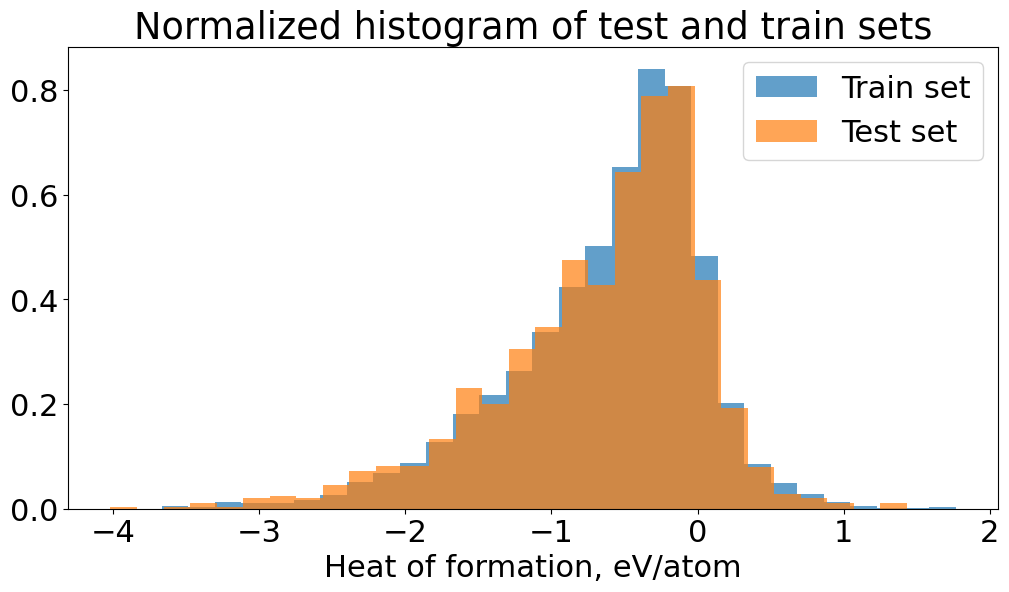

In [40]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=251)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()
